In [1]:
import phoebe

import emcee
import matplotlib.pyplot as plt


from scipy.stats import norm

from matplotlib.pyplot import cm 
import schwimmbad
import corner
from timeit import default_timer as timer
import pickle
import sys

import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1" 

import numpy as np

%matplotlib inline

In [2]:
# intialize the bundle.
b = phoebe.default_binary()

In [3]:
b['period@orbit'] = 0.5
b['sma@orbit'] = 3.5
b['incl@orbit'] = 83.5
b['requiv@primary'] = 1.2
b['requiv@secondary'] = 0.8
b['teff@primary'] = 6500.
b['teff@secondary'] = 5500.

true_values=(83.5,1.2,0.8,5500)

In [4]:
b.add_dataset('lc', times=np.linspace(0, 1, 51))

<ParameterSet: 80 parameters | contexts: dataset, figure, compute, constraint>

In [5]:
b.run_compute()

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 61.12it/s]


<ParameterSet: 3 parameters | qualifiers: fluxes, comments, times>

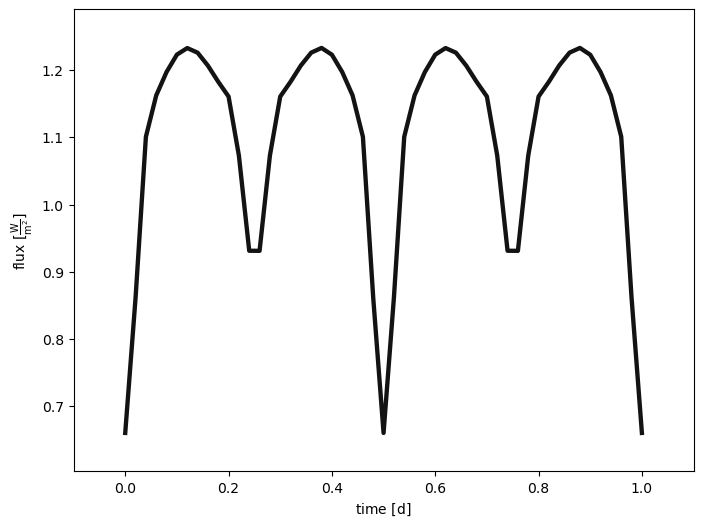

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [6]:
b.plot(show=True)

In [7]:

# Adding scatter to the synthetic light curve, saving to the file 'data.lc'. 
# Used as the "observed" light curve to fit.
np.savetxt('data.lc', 
           np.vstack((b['value@times@lc01@model'], b['value@fluxes@lc01@model']+np.random.normal(0, 0.001, 51))).T)

In [8]:
# loading 'data.lc' file into an LC dataset
(times, fluxes) = np.loadtxt('data.lc', unpack=True)
sigma_arr = np.zeros(len(times)) + 0.001


<ErrorbarContainer object of 3 artists>

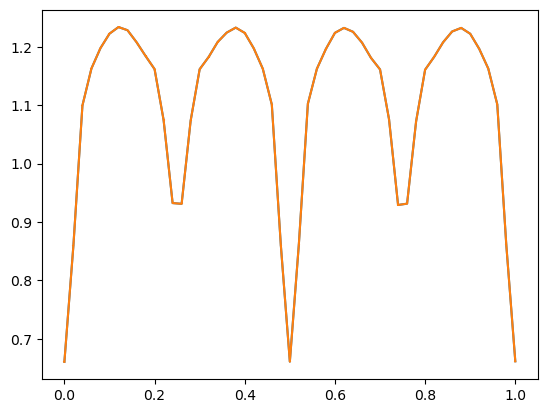

In [9]:
plt.plot(times,fluxes)
plt.errorbar(times,fluxes,yerr=sigma_arr)

In [10]:
# Initial parameters 
nwalkers = 20
niter = 1000
# Order(incl,r1,r2,teff2)
init_dist = [(80,85),(1.15,1.25),(0.75,0.85),(5450,5550)]

In [11]:
# Uniform priors
priors = [(84,85),(1.15,1.25),(0.75,0.85),(5450,5550)]

In [12]:
# Initiating new bundle
c = phoebe.default_binary()
c.add_dataset(phoebe.dataset.lc, times=times, fluxes=fluxes, 
              sigmas=sigma_arr, compute_phases=np.linspace(0,1.,51), 
              passband='Kepler:mean', dataset='lc02', overwrite=True)

<ParameterSet: 80 parameters | contexts: dataset, figure, compute, constraint>

In [13]:
c.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
c.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(100)
c.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(100)

In [14]:
c.set_value_all('ld_mode', 'manual')
c.set_value_all('ld_func', 'linear')
c.set_value_all('ld_coeffs', [0.])
c.set_value_all('ld_mode_bol', 'manual')
c.set_value_all('ld_func_bol', 'linear')
c.set_value_all('ld_coeffs_bol', [0.])
c.set_value('pblum_mode',value='dataset-scaled') # So the model is automatically scaled to the data 


In [15]:
# Setting values of the period, sma and primary teff
c['period@orbit'] = 0.5
c['sma@orbit'] = 3.5
c['teff@primary'] = 6500.

### rpars function

In [16]:
def rpars(init_dist):
    '''
    Pick a starting point from a uniform distributions
    '''
    return [np.random.rand() * (i[1]-i[0]) + i[0] for i in init_dist]

In [17]:
def lnprior(priors, values):
    '''
    Using a uniform prior, so values outside the prior range are set to -infinity
    '''  
    
    lp = 0.
    for value, prior in zip(values, priors):
        if value >= prior[0] and value <= prior[1]:
            lp+=0
        else:
            lp+=-np.inf 
    return lp

In [18]:
def lnprob(model_params,sigma_arr):
    '''
    Calculate the probability for each dataset. 
    '''
    # Model_params order(incl,r1,r2,teff2)

    c['incl@binary@orbit@component'] = model_params[0]
    c['requiv@primary@star@component'] = model_params[1]
    c['requiv@secondary@star@component'] = model_params[2]
    c['teff@secondary@star@component'] = model_params[3]
    
    # Get the log prior probabilities
    lnp = lnprior(priors,model_params)
    if not np.isfinite(lnp):
            return -np.inf
    
    try: 
        c.run_compute()

        # Chi^2 to compare the model to the data:
        chi2 = 0.
        # Compute_residuals only works on LC and RV dataset types
        # This will make the final chi2 a sum across all of these.
        for dataset in c.get_model().datasets:
            chi2+=np.sum(c.calculate_residuals(dataset=dataset, as_quantity=False)**2/sigma_arr**2)
        # Calculate lnprob
        lnprob = -0.5*chi2 + lnp
        return lnprob
    except:
        return -np.inf

In [19]:
# replaced xrang with range, 
# matplotlib.mlab.normpdf is deprecated, used scipy.stats.norm.pdf instead, 


true_values=(83.5,1.2,0.8,5500)
priors = [(83,84),(1.15,1.25),(0.75,0.85),(5450,5550)]

# Order(incl,r1,r2,teff2)
init_dist = [(80,85),(1.15,1.25),(0.75,0.85),(5450,5550)]
def rpars(init_dist):
    '''
    Pick a starting point from a uniform distributions
    '''
    return [np.random.rand() * (i[1]-i[0]) + i[0] for i in init_dist]

def run(init_dist1, nwalkers, niter, sigma_arr, true_values):
    # Specify the number of dimensions for mcmc
    ndim = len(init_dist)

    # Creates an array of initial positions for a set of walkers, for the Markov Chain Monte Carlo (MCMC) algorithm.
    p0 = np.array([rpars(init_dist) for i in range(nwalkers)])

    # Generate the emcee sampler. Here the inputs provided include the lnprob function. With this setup, the value z
    # in the lnprob function, is the output from the sampler.
    with schwimmbad.MultiPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,  args=(sigma_arr,), pool=pool)

        # sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(sigma_arr,),pool=pool)
    
    # pos is the position of the walkers in parameter space
    # prob is the probability of the given "pos" positions
    # state is the state of the random number generator
        start = timer()
        pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)
        print("Total time: {:.2f}".format((timer() - start)/60.0 ))


    return pos, sampler

In [20]:
# help(emcee.EnsembleSampler)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def hist_fig(samples, ndim, true_val):
    labels = ["$incl$", "$r_1$", "$r_2$", "$teff_2$"]
    labels2 = ["incl", "r_1", "r_2", "teff_2"]
    for i in range(ndim):
        fig = plt.figure()
        y = samples[:, i]
        n, bins, patches = plt.hist(y, 200, density=True, color="b", alpha=0.45)

        plt.title("Dimension {}".format(i))
        
        mu = np.average(y)
        sigma = np.std(y)
        
        print("mu = ", mu)
        print("sigma = ", sigma)

        bf = norm.pdf(bins, mu, sigma)
        l = plt.plot(bins, bf, 'k--', linewidth=2.0)
        plt.gca().axvline(true_val[i])
        plt.savefig("{}.pdf".format(labels2[i]))
        
    plt.show()
    return fig



In [22]:
def fit_plot(mod,sampler,nwalkers,times,true_value,ndim):
    
    # Plot actual data
    times = c.get_value(dataset='lc02',qualifier='times',context='dataset')
    fluxes = c.get_value(dataset='lc02',qualifier='fluxes',context='dataset')
    fig= plt.plot(times,fluxes,'.k')
    
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    
    # Limit number of samples to 100
    size=len(samples) #For small numbers of samples    
    if size > 20:
        size = 20
    for model_params in samples[np.random.randint(len(samples), size=size)]:
        # Model_params order(incl,r1,r2,teff2)
        c.set_value(qualifier='incl',context='component', component='binary',value=model_params[0])
        c.set_value(qualifier='requiv',context='component', component='primary',value=model_params[1])
        c.set_value(qualifier='requiv',context='component', component='secondary',value=model_params[2])
        c.set_value(qualifier='teff',component='secondary',value=model_params[3])
        
        c.run_compute(overwrite=True)
        
        model = c.get_parameter(context='model',qualifier='fluxes').interp_value(times=times)
        plt.savefig("fit_plot.pdf")

        plt.plot(times,model,c='k',alpha=0.001)
        
  
    plt.xlabel("Times")
    plt.ylabel("Flux")
    plt.show()
    return fig
    

In [23]:
# run model, save as sampler
# pos,sampler = run(init_dist, nwalkers, niter, sigma_arr,true_values)


In [24]:
# pickle option  
# pickle.dump(sampler,open('Run Name.p','wb'))

In [25]:
file_path = 'emcee_newfit_20w10000i150pts151_linsp.p'

with open(file_path, 'rb') as f:
    sampler = pickle.load(f)

In [26]:
# print(sampler.chain.shape)

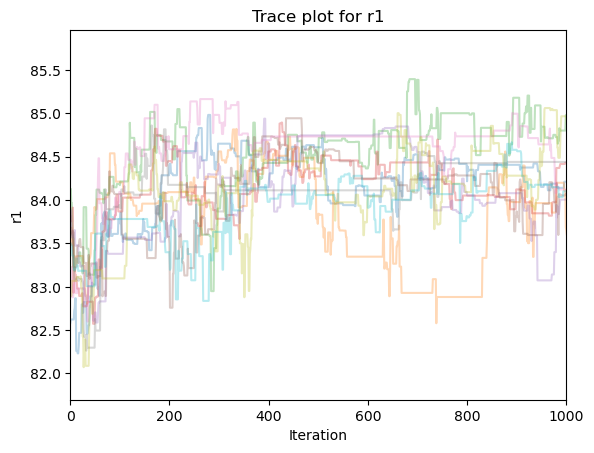

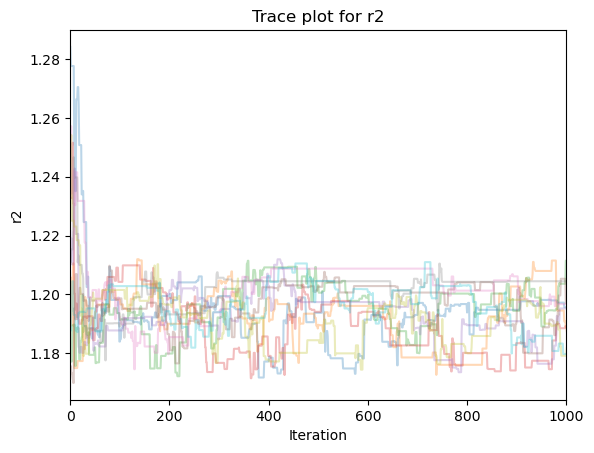

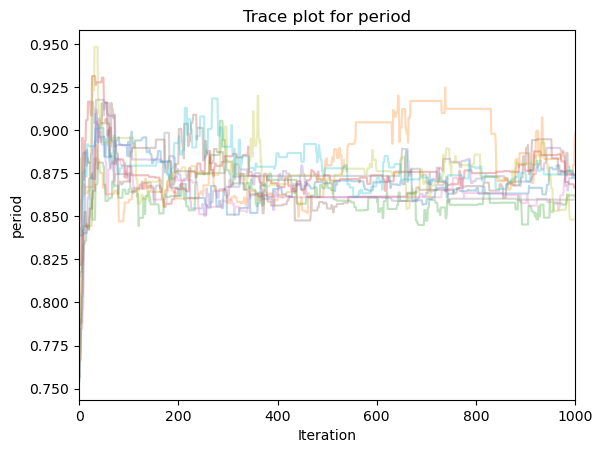

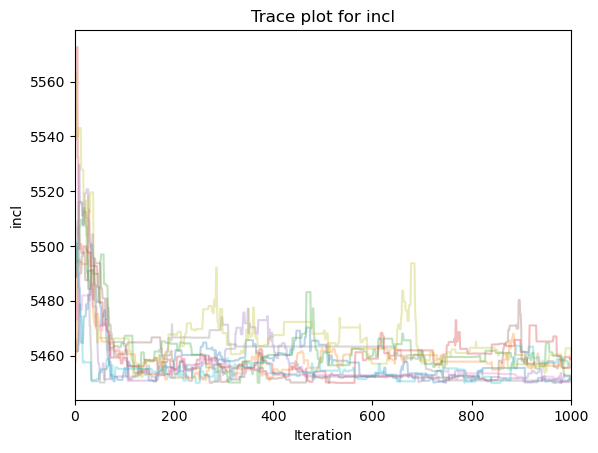

In [27]:
import matplotlib.pyplot as plt

for i, param in enumerate(['r1', 'r2', 'period', 'incl']):
    plt.figure(i)
    for j in range(10):
        plt.plot(sampler.chain[j, :, i], alpha=0.3)
    plt.xlim(0,1000)
    plt.xlabel('Iteration')
    plt.ylabel(param)
    plt.title(f'Trace plot for {param}')
plt.show()


In [28]:
burn_in = 250
ndim = len(init_dist)
samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

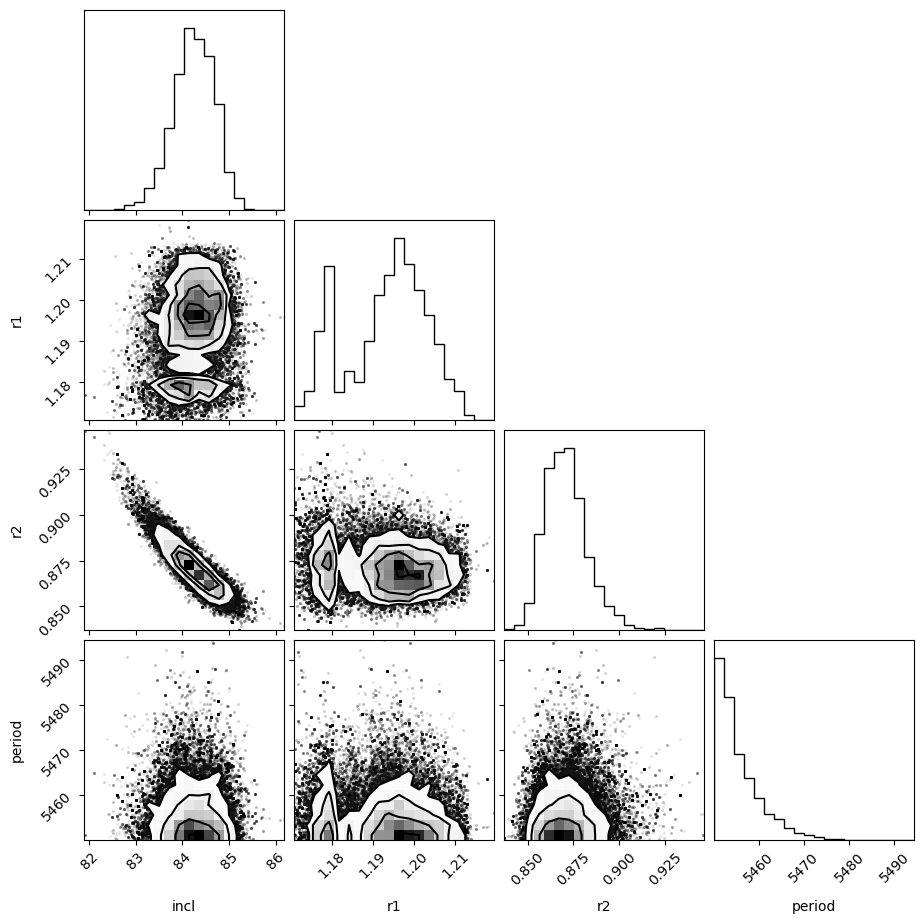

In [29]:
import corner

corner_fig = corner.corner(samples, labels=['incl','r1', 'r2', 'period', 'teff2'])
plt.show()



mu =  84.23489061671353
sigma =  0.44077578071754636
mu =  1.19316760026317
sigma =  0.009700253900406759
mu =  0.8710360860417083
sigma =  0.01178494520352002
mu =  5455.48653078126
sigma =  5.141233324185283


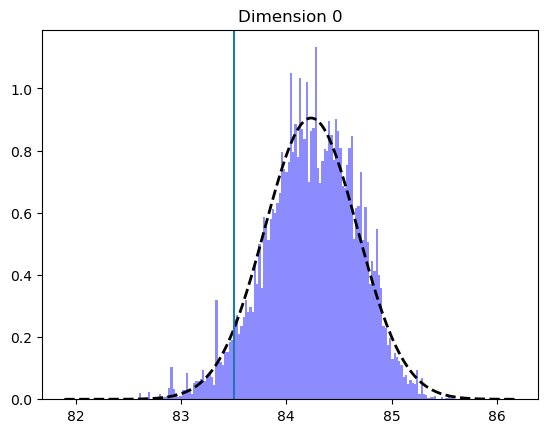

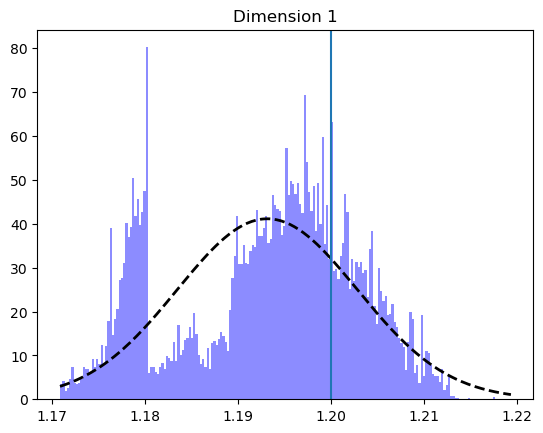

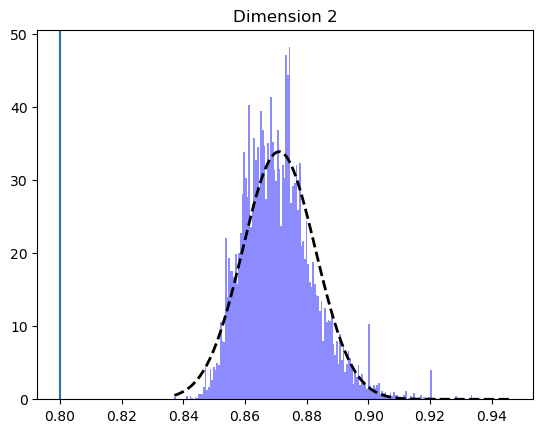

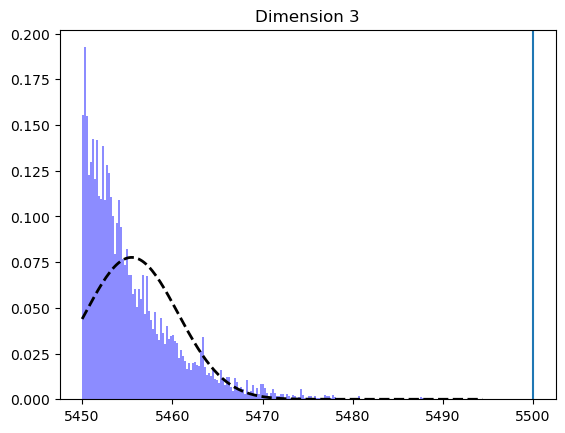

In [30]:

fig = hist_fig(samples,ndim,true_values)


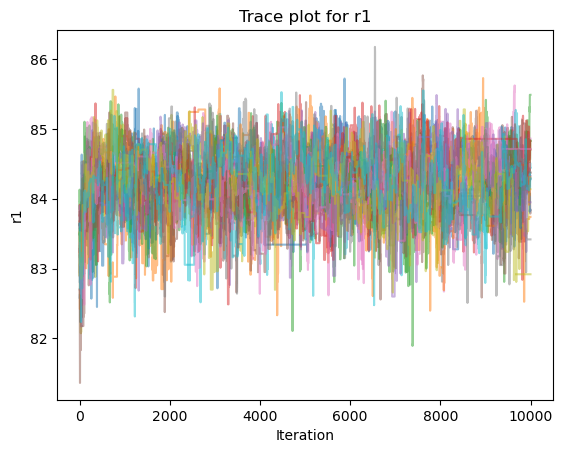

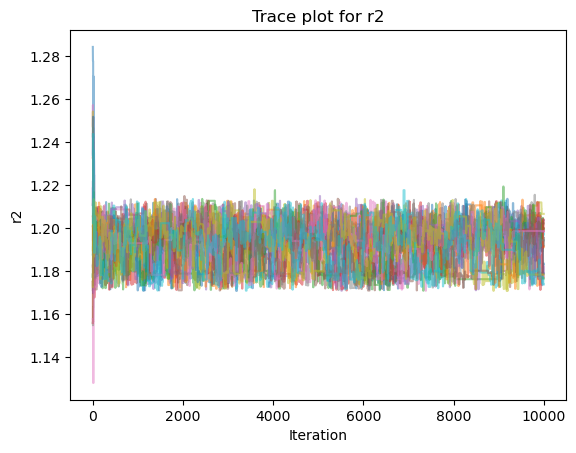

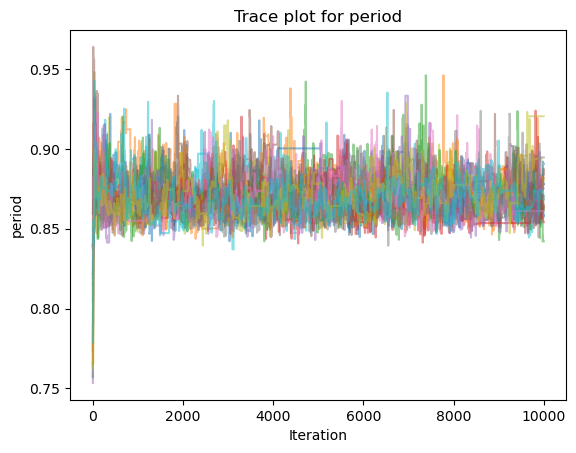

In [31]:
import matplotlib.pyplot as plt

for i, param in enumerate(['r1', 'r2', 'period']):
    plt.figure(i)
    for j in range(nwalkers):
        plt.plot(sampler.chain[j, :, i], alpha=0.5)
    plt.xlabel('Iteration')
    plt.ylabel(param)
    plt.title(f'Trace plot for {param}')
plt.show()


In [32]:
# print(len(init_dist))

# true_values=(83.5,1.2,0.8,5500)

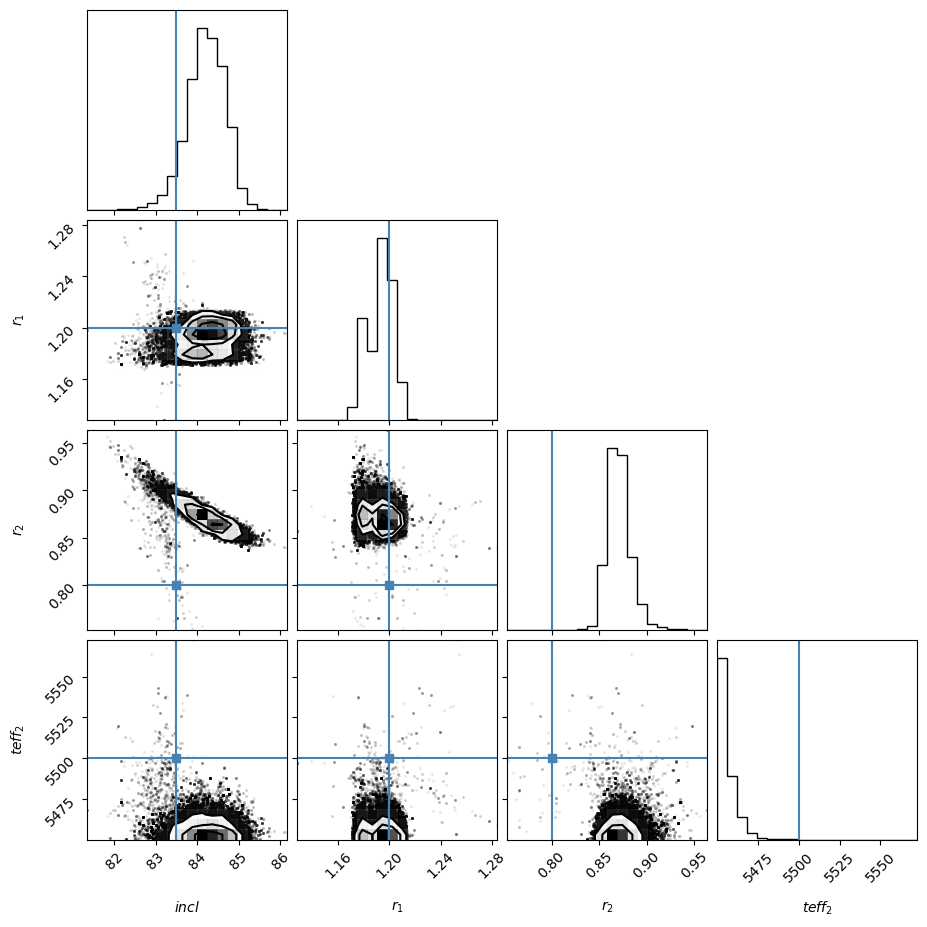

In [33]:
ndim = len(init_dist)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
corner.corner(samples, labels=["$incl$", "$r_1$", "$r_2$","$teff_2$"],truths=true_values)
plt.savefig("cornerplot.pdf")
fig = plt.show()


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 47.60it/s]


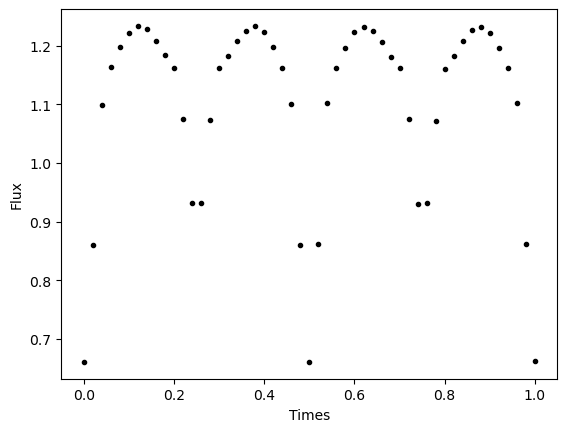

In [34]:
fig = fit_plot(c,sampler,nwalkers,times,true_values,ndim)



[83.         83.01010101 83.02020202 83.03030303 83.04040404 83.05050505
 83.06060606 83.07070707 83.08080808 83.09090909 83.1010101  83.11111111
 83.12121212 83.13131313 83.14141414 83.15151515 83.16161616 83.17171717
 83.18181818 83.19191919 83.2020202  83.21212121 83.22222222 83.23232323
 83.24242424 83.25252525 83.26262626 83.27272727 83.28282828 83.29292929
 83.3030303  83.31313131 83.32323232 83.33333333 83.34343434 83.35353535
 83.36363636 83.37373737 83.38383838 83.39393939 83.4040404  83.41414141
 83.42424242 83.43434343 83.44444444 83.45454545 83.46464646 83.47474747
 83.48484848 83.49494949 83.50505051 83.51515152 83.52525253 83.53535354
 83.54545455 83.55555556 83.56565657 83.57575758 83.58585859 83.5959596
 83.60606061 83.61616162 83.62626263 83.63636364 83.64646465 83.65656566
 83.66666667 83.67676768 83.68686869 83.6969697  83.70707071 83.71717172
 83.72727273 83.73737374 83.74747475 83.75757576 83.76767677 83.77777778
 83.78787879 83.7979798  83.80808081 83.81818182 83.

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 47.71it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 46.78it/s]


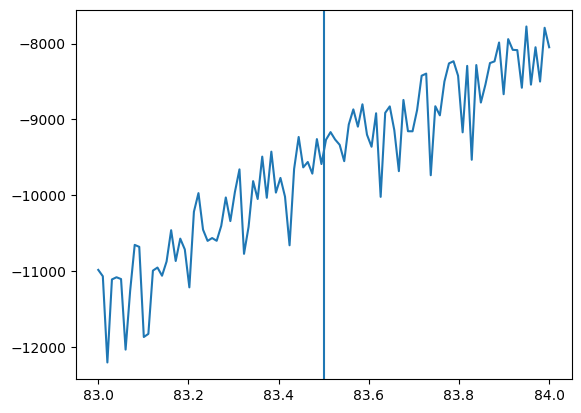

In [35]:
num = 100
incl_arr=np.linspace(83,84,num)
r1_arr=np.zeros(num) + true_values[1]
r2_arr=np.zeros(num) + true_values[2]
teff2_arr=np.zeros(num) + true_values[3]
print(incl_arr)

prob_list = list()
for i in np.arange(len(incl_arr)):
    prob_list.append(lnprob([incl_arr[i],r1_arr[i],r2_arr[i],teff2_arr[i]],sigma_arr))

prob_arr = np.array(prob_list)
plt.plot(incl_arr,prob_arr)
plt.gca().axvline(true_values[0])


[1.15       1.1510101  1.1520202  1.1530303  1.1540404  1.15505051
 1.15606061 1.15707071 1.15808081 1.15909091 1.16010101 1.16111111
 1.16212121 1.16313131 1.16414141 1.16515152 1.16616162 1.16717172
 1.16818182 1.16919192 1.17020202 1.17121212 1.17222222 1.17323232
 1.17424242 1.17525253 1.17626263 1.17727273 1.17828283 1.17929293
 1.18030303 1.18131313 1.18232323 1.18333333 1.18434343 1.18535354
 1.18636364 1.18737374 1.18838384 1.18939394 1.19040404 1.19141414
 1.19242424 1.19343434 1.19444444 1.19545455 1.19646465 1.19747475
 1.19848485 1.19949495 1.20050505 1.20151515 1.20252525 1.20353535
 1.20454545 1.20555556 1.20656566 1.20757576 1.20858586 1.20959596
 1.21060606 1.21161616 1.21262626 1.21363636 1.21464646 1.21565657
 1.21666667 1.21767677 1.21868687 1.21969697 1.22070707 1.22171717
 1.22272727 1.22373737 1.22474747 1.22575758 1.22676768 1.22777778
 1.22878788 1.22979798 1.23080808 1.23181818 1.23282828 1.23383838
 1.23484848 1.23585859 1.23686869 1.23787879 1.23888889 1.2398

100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 295.31it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 271.40it/s]


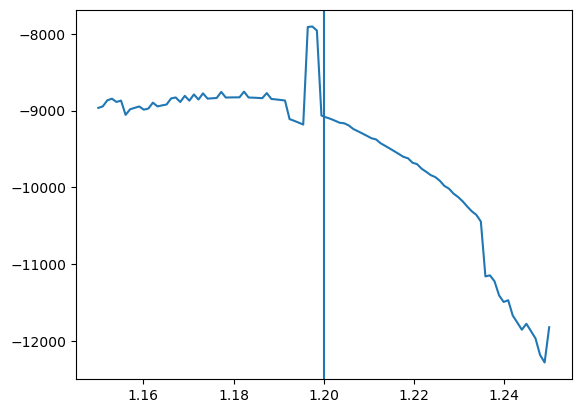

In [36]:
num = 100
r1_arr=np.linspace(1.15,1.25,num)
incl_arr=np.zeros(num) + true_values[0]
r2_arr=np.zeros(num) + true_values[2]
teff2_arr=np.zeros(num) + true_values[3]
print(r1_arr)

prob_list = list()
for i in np.arange(len(incl_arr)):
    prob_list.append(lnprob([incl_arr[i],r1_arr[i],r2_arr[i],teff2_arr[i]],sigma_arr))

prob_arr = np.array(prob_list)
plt.plot(r1_arr,prob_arr)
plt.gca().axvline(true_values[1])
